In [1]:
import sys, pathlib
sys.path.append(r'C:\Users\Wuestney\Documents\GitHub')
from tempfile import TemporaryFile
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json
from monte_carlo_sim.tests import check_simulated

## Check Samples Were Without Overlapping BitGenerators

From the command line, under the tests folder, run check_simulated.py to run through all samples and ensure bitgenerator states were handled correctly. If all statements return 'True' then samples are valid and analysis may proceed.

i.e.:

```dos
foo@bar:~$ python check_simulated.py "C:\..\monte_carlo_sim\simulation_output\simulation_output\simulated_2022-10-30"
```

## Define Monte Carlo Simulation Statistics

In [2]:
def bias_monteCarloSE(biasarray):
    nsim = len(biasarray)
    squaredsum=np.square(biasarray).sum()
    SE = np.sqrt(squaredsum*(1/(nsim*(nsim-1))))
    return SE

In [3]:
def empiric_SE(series):
    #empirical estimate of the sampling distribution SE
    nsim = len(series)
    squareddif = np.square(series - series.mean()).sum()
    empSE = np.sqrt((1/(nsim-1))*squareddif)
    return empSE
def empSE_MCSE(series):
    #Monte Carlo SE of the Empirical SE estimate
    nsim = len(series)
    empSE = empiric_SE(series)
    MCSE = empSE/np.sqrt(2*(nsim-1))
    return MCSE

## Generic routine for loading data from an estimates json file

* Step 1: Load json object of estimates data from json file.
* Step 2: Load a dataframe of the true theta values.
* Step 3: Load a dataframe of the estimated theta values for ApEN, SampEn, and RenyiUSM
* Step 4: Compute summary statistics of sampling distributions: mean and standard error of the empirical sampling distributions and Monte Carlo standard error of the Empirical Standard Error estimate
* Step 5: Check sampling distribution shapes for evidence of normality

In [4]:
# step 2: load dataframe of true theta values for bias calculations later if needed
def thetas_df(estimates_loaded):
    #takes loaded estimates json object
    #returns pandas dataframe
    
    thetas = pd.DataFrame.from_dict(estimates_loaded['Thetas'])
    return thetas

In [5]:
# step 3: load dataframe of entropy estimates
def theta_hats_df(estimates_loaded):
    # takes loaded estimates json object
    # outputs pandas dataframe with multi-index index and multi-index columns
    # index levels are 0=sample name, 1=sample size, 2=specific sample integer id
    
    #load dataframe of the SampEn and ApEn estimates
    theta_hats = pd.json_normalize(data=estimates_loaded, record_path=['Estimates', 'values', 'theta_hats'],
                                   meta=[['Estimates', "sampname"], ['Estimates', "nobs"], ['Estimates', "values", "sample"]])

    # reshape theta_hats df with a multi-index and multi-index columns so that each cell is the estimate of 
    # one type of entropy using one kernel size for one sample of one nobs size
    theta_hats_wide = pd.pivot(theta_hats, index=['Estimates.sampname', 'Estimates.nobs', 'Estimates.values.sample'], columns=['m'], values=['apen', 'sampen'])
    theta_hats_wide.columns = theta_hats_wide.columns.set_names(['entropy', 'kernel'])
    
    # replace 'Undefined' SampEn values with numpy nan
    theta_hats_wide = theta_hats_wide.replace('Undefined', np.nan)
    
    #load dataframe of the USMRenyi estimates
    renyi_hats = pd.json_normalize(data=estimates_loaded, record_path=['Estimates', 'values', 'renyi_hats'],
                                   meta=[['Estimates', "sampname"], ['Estimates', "nobs"], ['Estimates', "values", "sample"]])
    renyi_hats.set_index(['Estimates.sampname', 'Estimates.nobs', 'Estimates.values.sample'], inplace=True)
    # reshape index and columns to match structure of SampEn/ApEn df
    renyi_cols = pd.MultiIndex.from_product([["renyi"], renyi_hats.columns], names=["entropy", "kernel"])
    renyi_hats.columns = renyi_cols
    # merge SampEn, ApEn, and USMRenyi estimates dataframes
    dfestswide = pd.merge(theta_hats_wide, renyi_hats, how='outer', on=['Estimates.sampname', 'Estimates.nobs', 'Estimates.values.sample'])
    return dfestswide

In [18]:
# step 4: compute mean, empirical SE and Monte Carlo SE of EmpSE estimate
def theta_hats_agg(theta_hats):
    dfests_agg = theta_hats.groupby(level=1).agg(["mean", empiric_SE, empSE_MCSE])
    #to get a dataframe of overall stats not grouped by sample size use following command
    #dfests_agg = dfestswide.agg(["mean", empiric_SE, empSE_MCSE], axis=0)
    return dfests_agg

## Results for IID Uniform Random Distributions

### Alphabet Size 18

In [7]:
iida18estspath = pathlib.Path(r"C:\Users\Wuestney\Documents\GitHub\monte_carlo_sim\simulation_output\simulation_output\estimates_2022-11-16\iiduniA18Nsim10000_2022-11-16T172922_estimates.json")

In [11]:
# step 1: load json object of estimates data from json file
with open(iida18estspath, 'r') as fhand:
    estimates_loaded = json.load(fhand)

In [12]:
#estimates_loaded

Read thetas dataset into a Pandas Dataframe

In [13]:
# step 2: load dataframe of true theta values for bias calculations later if needed
thetas = thetas_df(estimates_loaded)

Load a dataframe of the entropy estimates

In [14]:
# step 3: load dataframe of entropy estimates
theta_hats = theta_hats_df(estimates_loaded)

C:\Users\Wuestney\miniconda3\envs\monte-carlo-dev\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [15]:
theta_hats

entropy                                                        apen            \
kernel                                                            1         2   
Estimates.sampname Estimates.nobs Estimates.values.sample                       
iiduniA18N1000     1000           0                        2.707911  1.189594   
                                  1                        2.731248  1.176623   
                                  2                        2.706945  1.192582   
                                  3                        2.747239  1.180909   
                                  4                        2.704494  1.201373   
...                                                             ...       ...   
iiduniA18N5000     5000           9995                     2.860866  2.271499   
                                  9996                     2.858981  2.248489   
                                  9997                     2.855801  2.265094   
                                  9998                     2.860514  2.255949   
                                  9999                     2.861491  2.262923   

entropy                                                                        \
kernel                                                            3         4   
Estimates.sampname Estimates.nobs Estimates.values.sample                       
iiduniA18N1000     1000           0                        0.118898  0.005567   
                                  1                        0.101688  0.011135   
                                  2                        0.115252  0.005567   
                                  3                        0.097517  0.001392   
                                  4                        0.110556  0.004176   
...                                                             ...       ...   
iiduniA18N5000     5000           9995                     0.465424  0.027853   
                                  9996                     0.483079  0.034963   
                                  9997                     0.479156  0.026743   
                                  9998                     0.477673  0.031947   
                                  9999                     0.473807  0.028235   

entropy                                                      sampen            \
kernel                                                            1         2   
Estimates.sampname Estimates.nobs Estimates.values.sample                       
iiduniA18N1000     1000           0                        2.869795  2.830653   
                                  1                        2.903239  2.888386   
                                  2                        2.854211  2.848442   
                                  3                        2.938458  2.976210   
                                  4                        2.871934  2.905293   
...                                                             ...       ...   
iiduniA18N5000     5000           9995                     2.893646  2.912017   
                                  9996                     2.890509  2.849150   
                                  9997                     2.882710  2.898148   
                                  9998                     2.892513  2.874074   
                                  9999                     2.894695  2.896285   

entropy                                                                        \
kernel                                                            3         4   
Estimates.sampname Estimates.nobs Estimates.values.sample                       
iiduniA18N1000     1000           0                        3.135494       NaN   
                                  1                        2.233592  2.197225   
                                  2                        2.730029  1.098612   
                                  3                        4.317488       NaN   
                            

In [16]:
#theta_hats_wide

In [19]:
# step 4: 
dfests_agg = theta_hats_agg(theta_hats)
dfests_agg

entropy             apen                                             \
kernel                 1                               2              
                    mean empiric_SE empSE_MCSE      mean empiric_SE   
Estimates.nobs                                                        
500             2.532943   0.024772   0.000175  0.747334   0.024069   
1000            2.722421   0.013644   0.000096  1.187343   0.014722   
2500            2.827489   0.005086   0.000036  1.836127   0.009719   
5000            2.859368   0.002527   0.000018  2.264908   0.007866   

entropy                                                              ...  \
kernel                            3                               4  ...   
               empSE_MCSE      mean empiric_SE empSE_MCSE      mean  ...   
Estimates.nobs                                                       ...   
500              0.000170  0.054444   0.011999   0.000085  0.003074  ...   
1000             0.000104  0.107682   0.011333   0.000080  0.006150  ...   
2500             0.000069  0.256162   0.009895   0.000070  0.015502  ...   
5000             0.000056  0.471077   0.007700   0.000054  0.030834  ...   

entropy                renyi                                                 \
kernel              17.78279   31.62278                            56.23413   
                  empSE_MCSE       mean empiric_SE    empSE_MCSE       mean   
Estimates.nobs                                                                
500             7.784521e-07  53.869099   0.000062  4.380829e-07  59.047734   
1000            5.555251e-07  53.869097   0.000044  3.126299e-07  59.047733   
2500            3.485859e-07  53.869096   0.000028  1.961731e-07  59.047733   
5000            2.469630e-07  53.869095   0.000020  1.389833e-07  59.047732   

entropy                                                                      
kernel                                       100.0                           
               empiric_SE    empSE_MCSE       mean empiric_SE    empSE_MCSE  
Estimates.nobs                                                               
500              0.000035  2.464557e-07  64.227325   0.000020  1.386250e-07  
1000             0.000025  1.758791e-07  64.227324   0.000014  9.892763e-08  
2500             0.000016  1.103633e-07  64.227324   0.000009  6.207676e-08  
5000             0.000011  7.818952e-08  64.227324   0.000006  4.397979e-08  

[4 rows x 171 columns]

In [20]:
#theta_empse = theta_hats_wide.agg(empiric_SE, axis=0)

In [21]:
#renyi_means = renyi_hats.mean()

In [22]:
# compute mean and standard error of the empirical sampling distributions of ApEn and SampEn
#theta_agg = theta_hats_wide.groupby(level=1).agg(["mean", empiric_SE, empSE_MCSE])

In [23]:
#dfests_agg = dfestswide.agg(["mean", empiric_SE, empSE_MCSE], axis=0)

In [24]:
apen_empSE = dfests_agg["apen"].filter(regex='empiric_SE').T.droplevel(1)

In [25]:
apen_empSE_MCSE = dfests_agg["apen"].filter(regex="empSE_MCSE").T.droplevel(1)

<AxesSubplot:xlabel='kernel', ylabel='mean ApEn (nsim 10000)'>

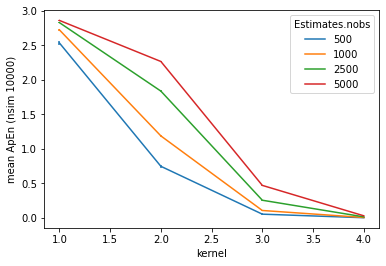

In [26]:
apen_means = dfests_agg["apen"].filter(regex='mean').T.droplevel(1)
apen_means.plot(ylabel='mean ApEn (nsim 10000)', yerr=apen_empSE)

<AxesSubplot:xlabel='kernel', ylabel='Empirical ApEn Standard Error (nsim 10000)'>

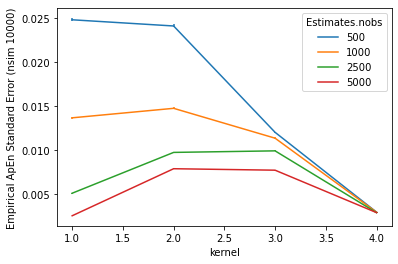

In [27]:
apen_empSE.plot(ylabel='Empirical ApEn Standard Error (nsim 10000)', yerr=apen_empSE_MCSE)

In [28]:
#dfests_agg["apen"].transpose()["mean"].plot()

In [29]:
sampen_empSE = dfests_agg["sampen"].filter(regex='empiric_SE').T.droplevel(1)
sampen_empSE_MCSE = dfests_agg["sampen"].filter(regex="empSE_MCSE").T.droplevel(1)
sampen_means = dfests_agg["sampen"].filter(regex='mean').T.droplevel(1)

<AxesSubplot:xlabel='kernel', ylabel='mean SampEn (nsim 10000)'>

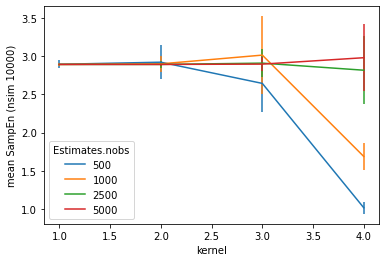

In [30]:
sampen_means.plot(ylabel='mean SampEn (nsim 10000)', yerr=sampen_empSE)

<AxesSubplot:xlabel='kernel', ylabel='Empirical SampEn Standard Error (nsim 10000)'>

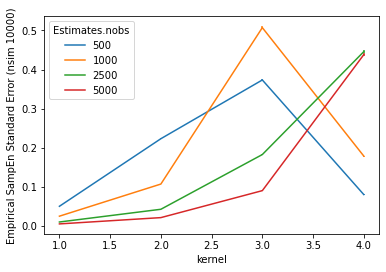

In [31]:
sampen_empSE.plot(ylabel='Empirical SampEn Standard Error (nsim 10000)', yerr=sampen_empSE_MCSE)

In [32]:
apen_sampen_means = dfests_agg[["apen","sampen"]].iloc[:, dfests_agg[["apen","sampen"]].columns.get_level_values(2)=='mean'].T.reset_index()
apen_sampen_SEs = dfests_agg[["apen","sampen"]].iloc[:, dfests_agg[["apen","sampen"]].columns.get_level_values(2)=='empiric_SE'].T.reset_index()

In [33]:
apen_sampen_SEs = apen_sampen_SEs.pivot(index='kernel', columns='entropy', values=5000)

C:\Users\Wuestney\miniconda3\envs\monte-carlo-dev\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


<AxesSubplot:xlabel='kernel'>

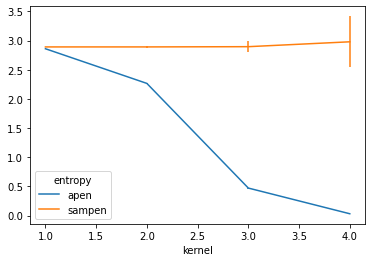

In [34]:
apen_sampen_means.pivot(index='kernel', columns='entropy', values=5000).plot(yerr=apen_sampen_SEs)

In [35]:
apen_sampen_means

Estimates.nobs,entropy,kernel,level_2,500,1000,2500,5000
0,apen,1,mean,2.532943,2.722421,2.827489,2.859368
1,apen,2,mean,0.747334,1.187343,1.836127,2.264908
2,apen,3,mean,0.054444,0.107682,0.256162,0.471077
3,apen,4,mean,0.003074,0.006150,0.015502,0.030834
4,sampen,1,mean,2.892382,2.890699,2.890405,2.890347
5,sampen,2,mean,2.919746,2.898060,2.890457,2.890581
6,sampen,3,mean,2.642896,3.012152,2.907444,2.894543
7,sampen,4,mean,1.019514,1.688817,2.815057,2.978167


In [36]:
renyi_empSE = dfests_agg["renyi"].filter(regex='empiric_SE').T.droplevel(1)
renyi_empSE_MCSE = dfests_agg["renyi"].filter(regex="empSE_MCSE").T.droplevel(1)
renyi_means = dfests_agg["renyi"].filter(regex='mean').T.droplevel(1)

In [53]:
renyi_means.loc['1e-05':]

Estimates.nobs,500,1000,2500,5000
kernel,,,,
1e-05,-74.622503,-73.929357,-73.013069,-72.319925
1.778279e-05,-69.441690,-68.748546,-67.832262,-67.139127
3.162278e-05,-64.260876,-63.567737,-62.651470,-61.958361
5.623413e-05,-59.080080,-58.386959,-57.470750,-56.777736
0.0001,-53.899322,-53.206258,-52.290227,-51.597503
0.0001778279,-48.718714,-48.025854,-47.110455,-46.418767
0.0003162278,-43.538550,-42.846345,-41.932944,-41.244538
0.0005623413,-38.359924,-37.669904,-36.763063,-36.085364
0.001,-33.186606,-32.504035,-31.619014,-30.975712


<AxesSubplot:xlabel='kernel', ylabel='mean USM-Renyi (nsim 10000)'>

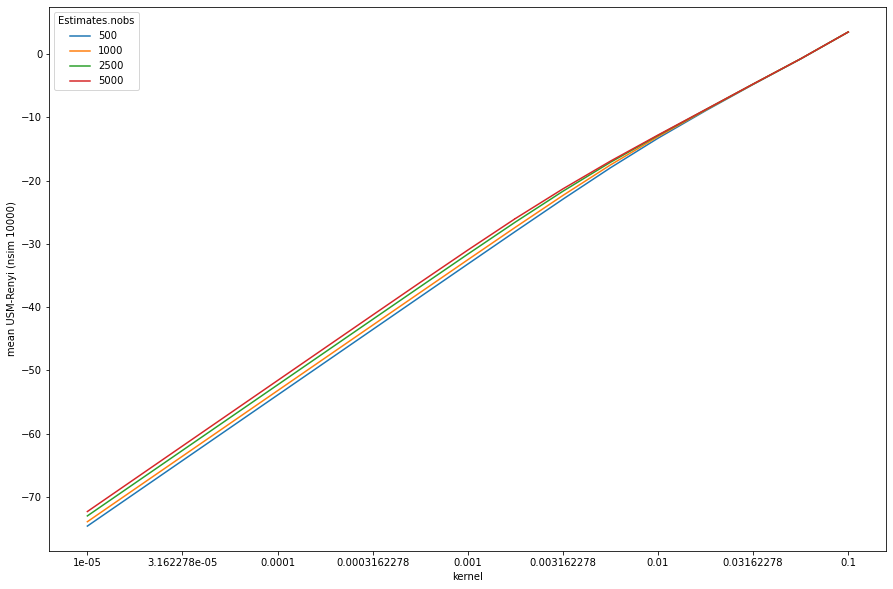

In [52]:
renyi_means.loc['1e-05':'0.1'].plot(ylabel='mean USM-Renyi (nsim 10000)', yerr=renyi_empSE.loc['1e-05':'0.1'], figsize=(15,10))

<AxesSubplot:xlabel='kernel', ylabel='Empirical USM-Renyi Standard Error (nsim 10000)'>

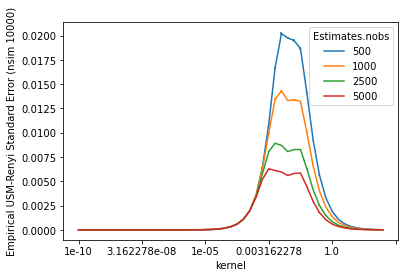

In [44]:
renyi_empSE.plot(ylabel='Empirical USM-Renyi Standard Error (nsim 10000)', yerr=renyi_empSE_MCSE)

In [39]:
#theta_hats_wide.hist(density=True, figsize=(30,30))

In [40]:
#renyi_hats.hist(density=True, figsize=(30,30))

In [41]:
#dfestswide.hist(figsize=(30, 30))

array([[<AxesSubplot:title={'center':"('apen', 1)"}>,
        <AxesSubplot:title={'center':"('apen', 2)"}>,
        <AxesSubplot:title={'center':"('apen', 3)"}>,
        <AxesSubplot:title={'center':"('apen', 4)"}>,
        <AxesSubplot:title={'center':"('sampen', 1)"}>,
        <AxesSubplot:title={'center':"('sampen', 2)"}>,
        <AxesSubplot:title={'center':"('sampen', 3)"}>,
        <AxesSubplot:title={'center':"('sampen', 4)"}>],
       [<AxesSubplot:title={'center':"('renyi', '1e-10')"}>,
        <AxesSubplot:title={'center':"('renyi', '1.778279e-10')"}>,
        <AxesSubplot:title={'center':"('renyi', '3.162278e-10')"}>,
        <AxesSubplot:title={'center':"('renyi', '5.623413e-10')"}>,
        <AxesSubplot:title={'center':"('renyi', '1e-09')"}>,
        <AxesSubplot:title={'center':"('renyi', '1.778279e-09')"}>,
        <AxesSubplot:title={'center':"('renyi', '3.162278e-09')"}>,
        <AxesSubplot:title={'center':"('renyi', '5.623413e-09')"}>],
       [<AxesSubplot:title={

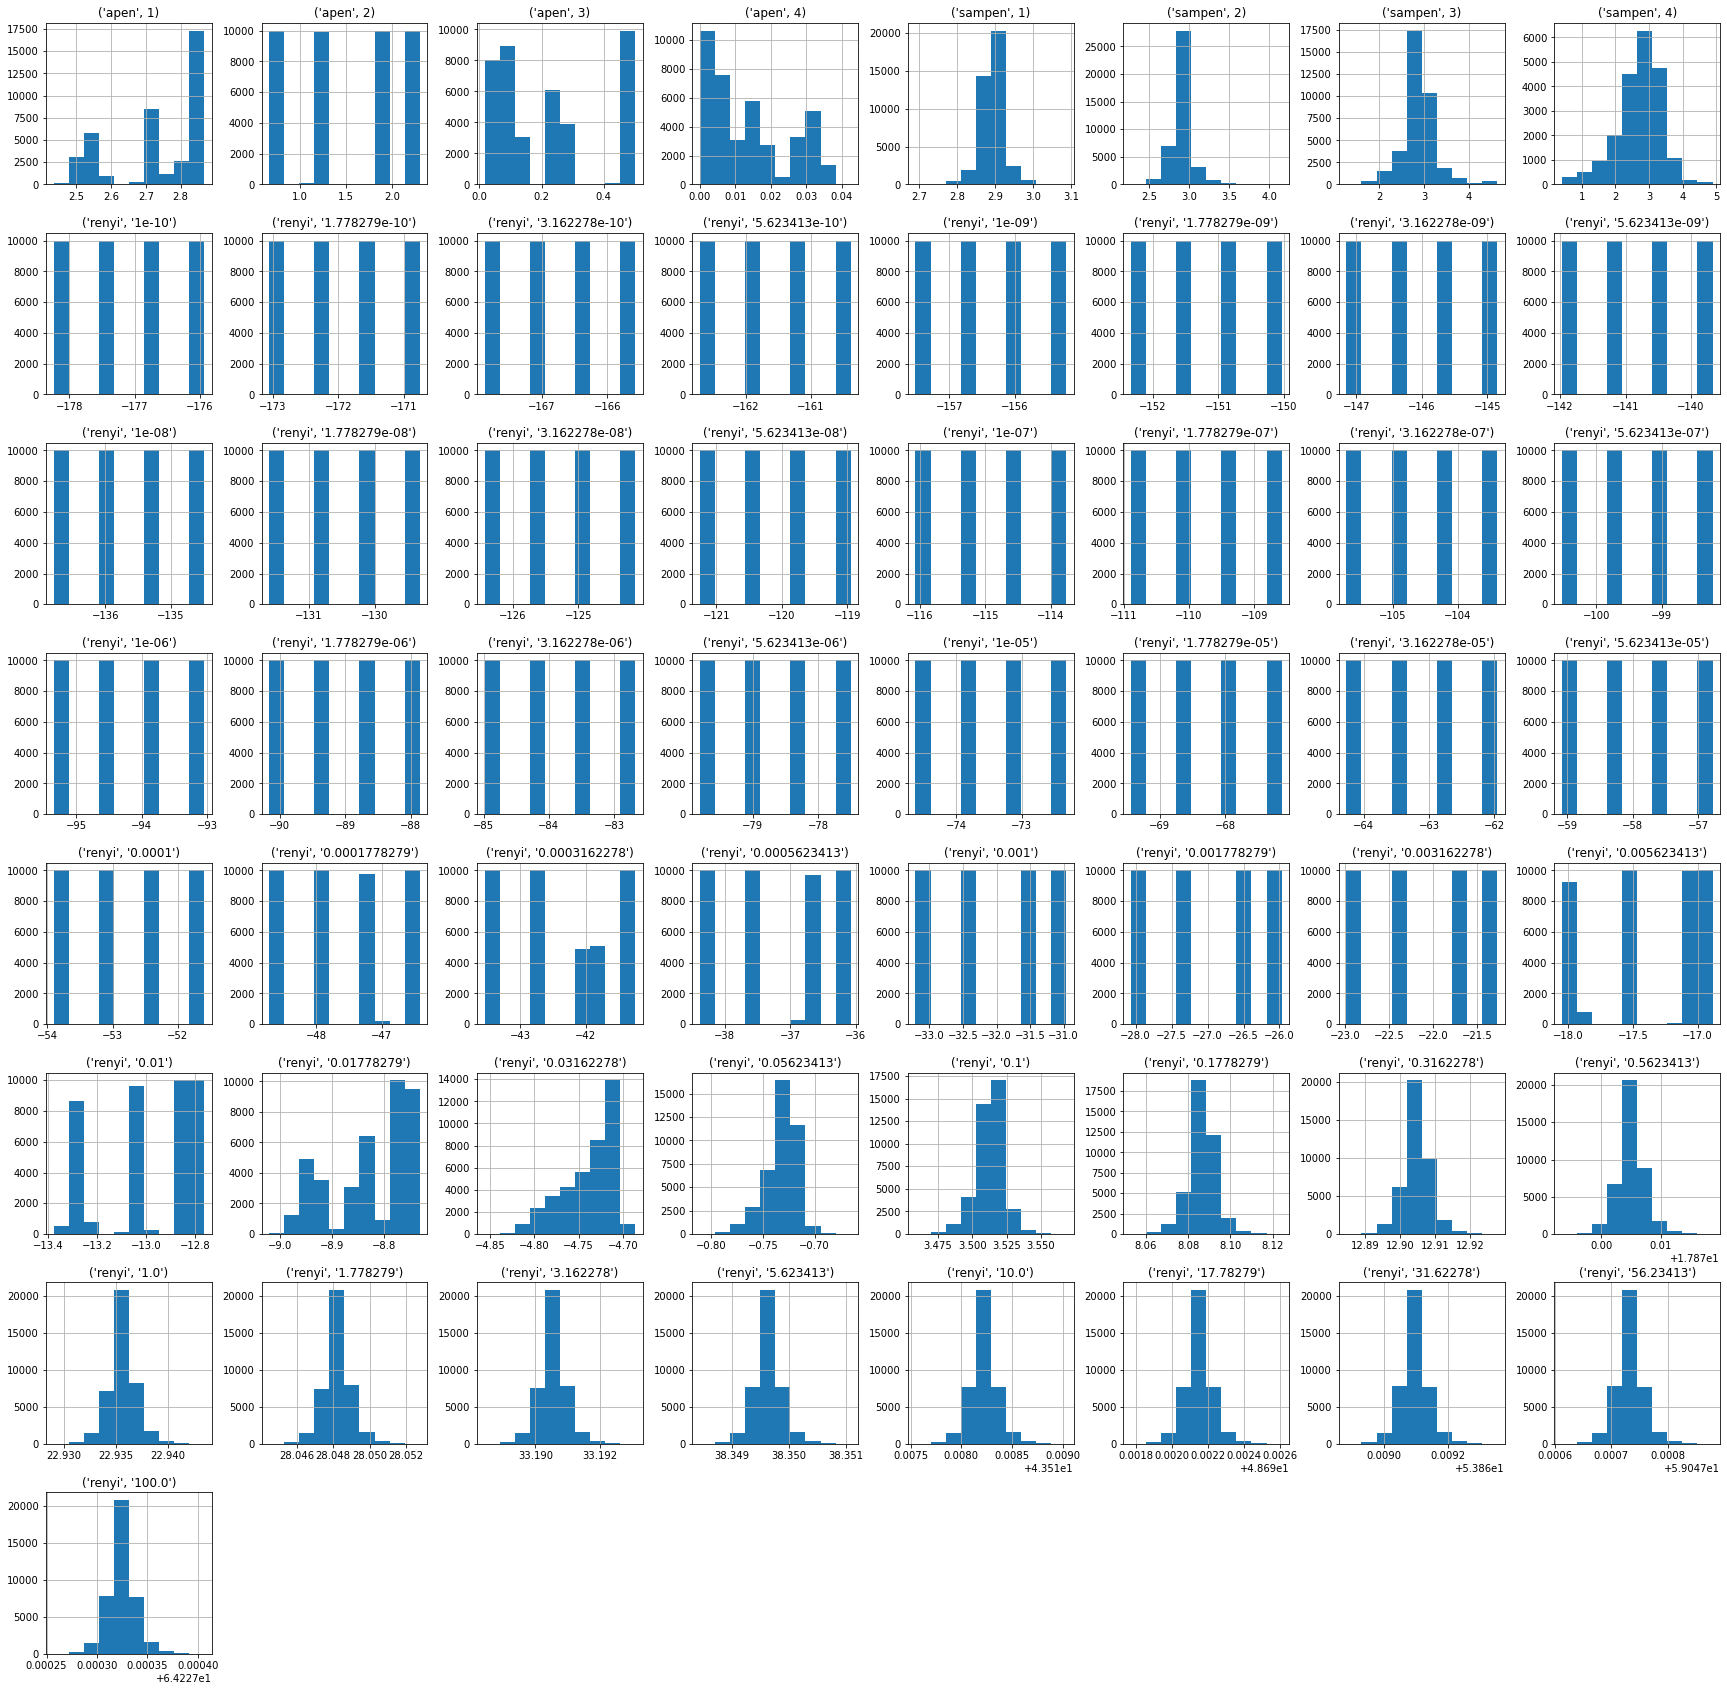

In [42]:
theta_hats.hist(figsize=(30,30))

array([[<AxesSubplot:title={'center':'1e-10'}>,
        <AxesSubplot:title={'center':'1.778279e-10'}>,
        <AxesSubplot:title={'center':'3.162278e-10'}>,
        <AxesSubplot:title={'center':'5.623413e-10'}>,
        <AxesSubplot:title={'center':'1e-09'}>,
        <AxesSubplot:title={'center':'1.778279e-09'}>,
        <AxesSubplot:title={'center':'3.162278e-09'}>],
       [<AxesSubplot:title={'center':'5.623413e-09'}>,
        <AxesSubplot:title={'center':'1e-08'}>,
        <AxesSubplot:title={'center':'1.778279e-08'}>,
        <AxesSubplot:title={'center':'3.162278e-08'}>,
        <AxesSubplot:title={'center':'5.623413e-08'}>,
        <AxesSubplot:title={'center':'1e-07'}>,
        <AxesSubplot:title={'center':'1.778279e-07'}>],
       [<AxesSubplot:title={'center':'3.162278e-07'}>,
        <AxesSubplot:title={'center':'5.623413e-07'}>,
        <AxesSubplot:title={'center':'1e-06'}>,
        <AxesSubplot:title={'center':'1.778279e-06'}>,
        <AxesSubplot:title={'center':'3.162

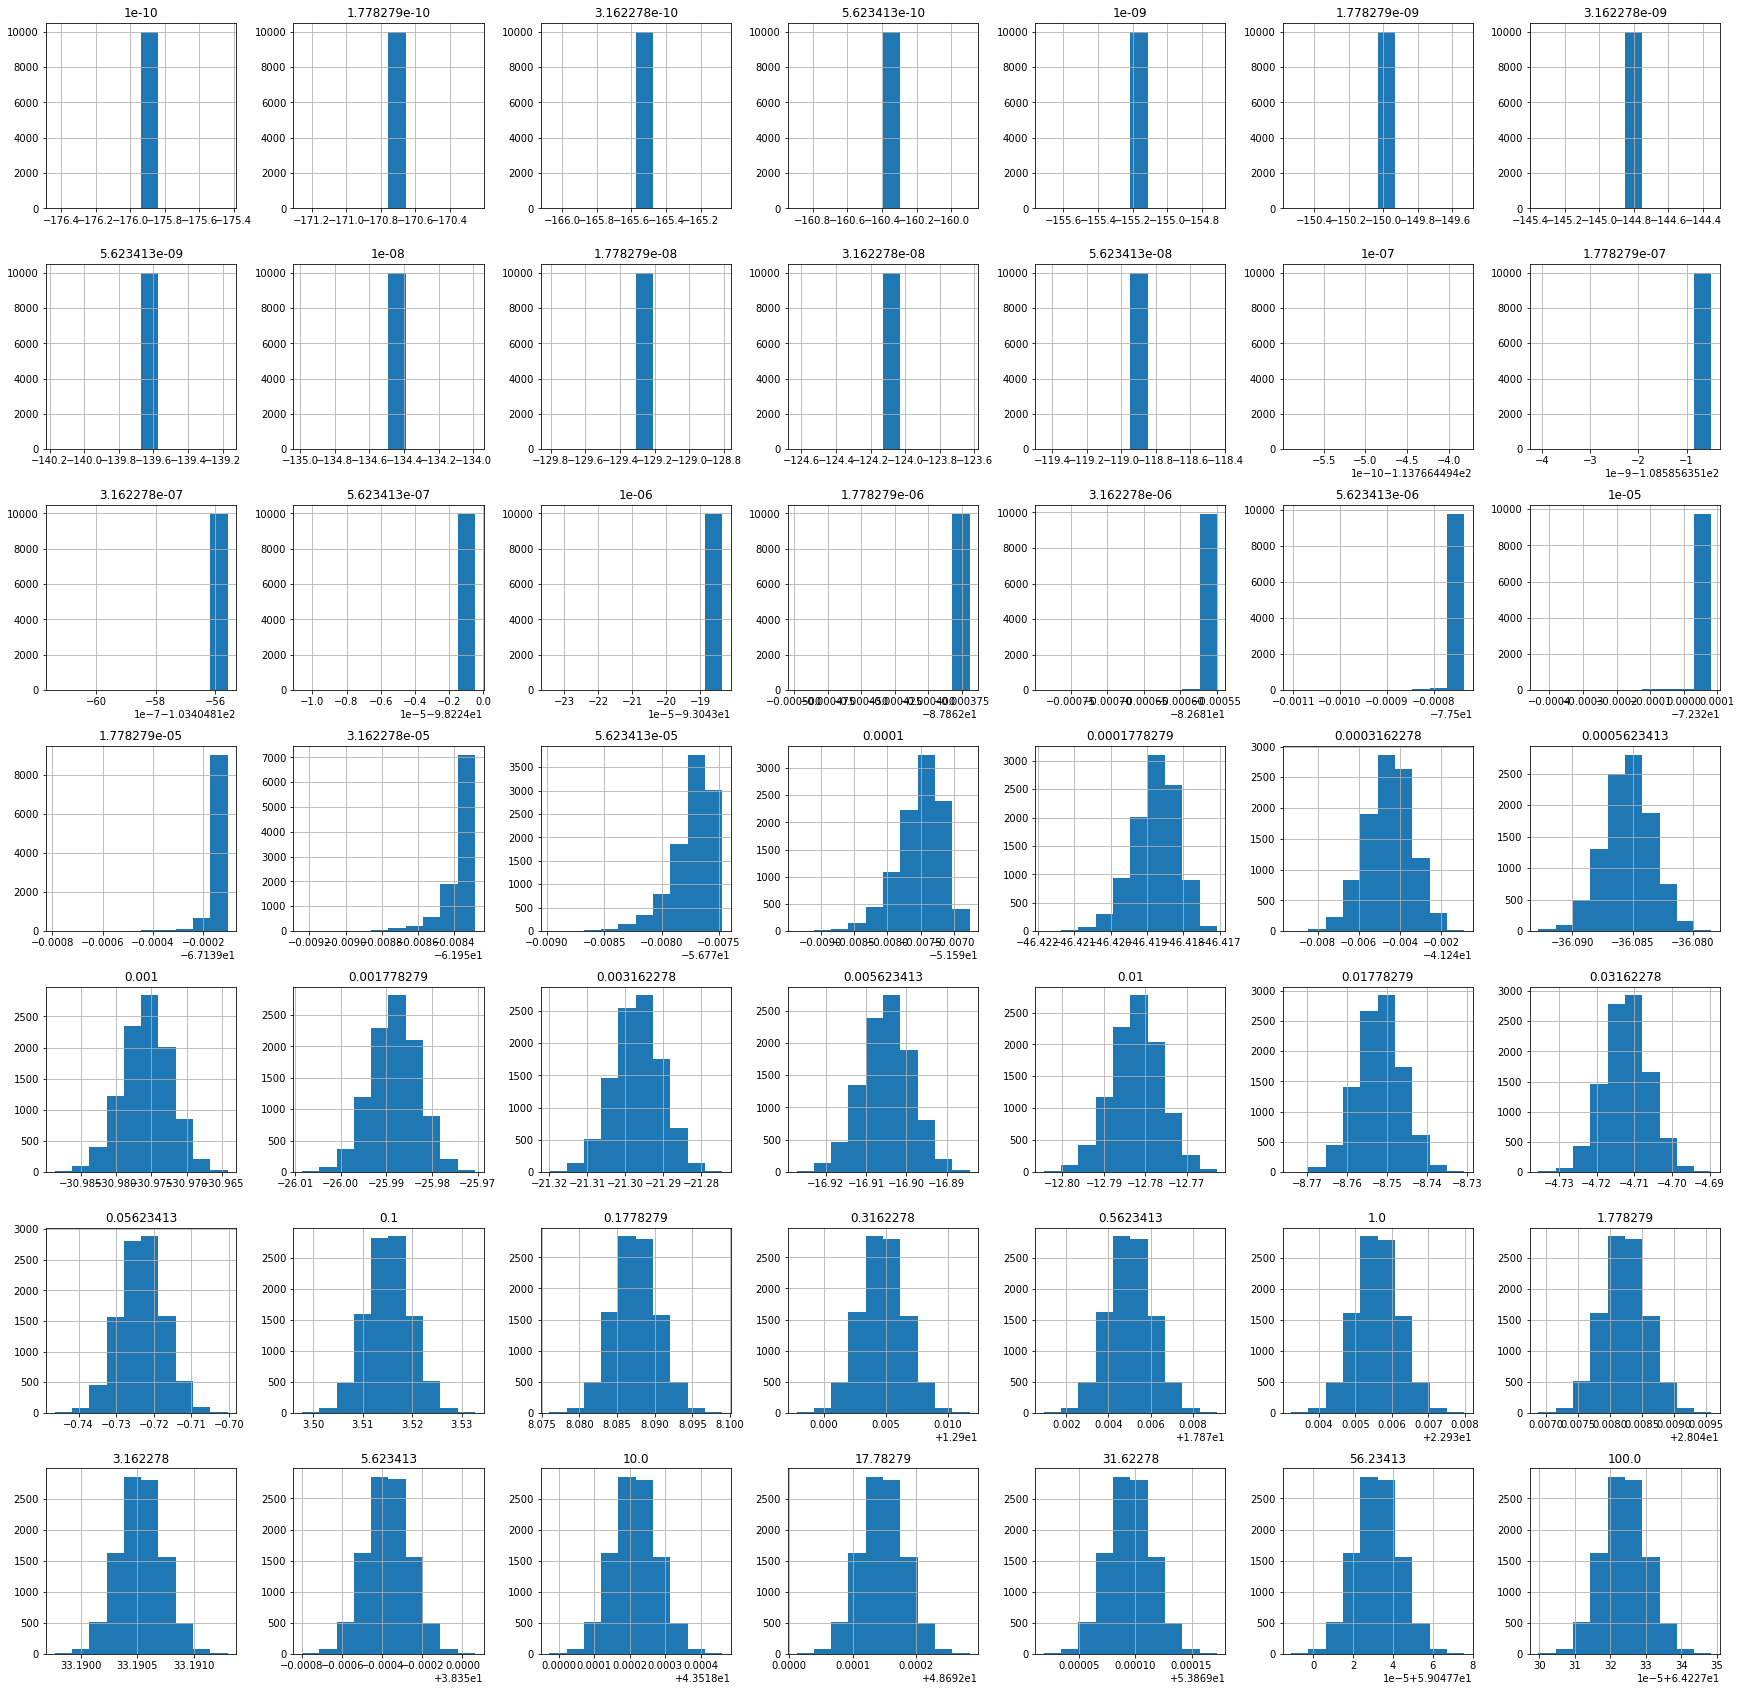

In [43]:
# check distribution shapes for USM-Renyi values at each kernel value
theta_hats["renyi"].loc[(slice(None), 5000),:].hist(figsize=(30, 30))